In [1]:
using DrWatson
quickactivate(@__DIR__)

import Baysor as B
import BaysorAnalysis as BA
import Colors
import Clustering
import ColorSchemes
import CSV
import CairoMakie as MK
import Images
import PyPlot as Plt
import Seaborn as Sns

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using OrderedCollections
using SparseArrays
using Statistics
using StatsBase

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()

cell_cols_aliases = OrderedDict(:cell => "Baysor", :cell_pciseq => "pciSeq", :cell_watershed => "Watershed", :cell_polya => "poly-A")
cell_cols = collect(keys(cell_cols_aliases))
color_per_label = BA.method_palette(collect(values(cell_cols_aliases)));

## Load data

In [2]:
@time data = BA.load_merfish(watershed=true, min_mols_per_cell=40);
rename!(data[:df], :cell_paper => :cell_polya);

@time poly_a_arr = Float16.(Images.load(datadir("exp_raw/merfish_moffit/polyA_merged.tiff")));
data[:df][!, :polya_brightness] = B.staining_value_per_transcript(data[:df], poly_a_arr);
df_spatial = data[:df];

 52.776663 seconds (74.18 M allocations: 10.554 GiB, 5.35% gc time, 21.66% compilation time)
  9.607381 seconds (1.14 M allocations: 1.510 GiB, 7.41% gc time, 9.16% compilation time)


In [3]:
@time BA.append_matching_statistics!(data, cell_cols, target_cell_col_names=[:cell_polya]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


 76.182838 seconds (48.16 M allocations: 15.434 GiB, 2.65% gc time, 24.51% compilation time)


## Prepare data

In [4]:
ovr_counts = vcat([DataFrame(:NCells => B.count_array(min.(data[s].n_overlaps[1], 3) .+ 1), :NOverlaps => ["0", "1", "2", "3+"], :Type => t)
    for (s,t) in zip([:match_res_cell_polya, :match_res_pciseq_polya, :match_res_watershed_polya], ["Baysor", "pciSeq", "Watershed"])]...);

In [5]:
grid_size = 7
x_grid, y_grid = [floor.(Int, grid_size .* (df_spatial[!,c] .- minimum(df_spatial[!,c])) ./ (maximum(df_spatial[!,c]) - minimum(df_spatial[!,c]) .+ 0.01)) 
    for c in [:x, :y]];
grid_labels = x_grid .+ grid_size .* y_grid .+ 1;
ids_per_grid = B.split_ids(grid_labels);

plot_cols = [:cell, :cell_watershed, :cell_pciseq];
@time mi_df = vcat([DataFrame(
    :mi => Clustering.mutualinfo(data[:assignment_filt][c][ids], data[:assignment_filt][:cell_polya][ids]),
    :lab => cell_cols_aliases[c]
) for c in plot_cols for ids in ids_per_grid]...);

 36.085049 seconds (1.35 M allocations: 36.510 GiB, 13.44% gc time, 4.90% compilation time)


In [6]:
countmap(mi_df.lab)

Dict{String, Int64} with 3 entries:
  "pciSeq"    => 49
  "Baysor"    => 49
  "Watershed" => 49

## Plot

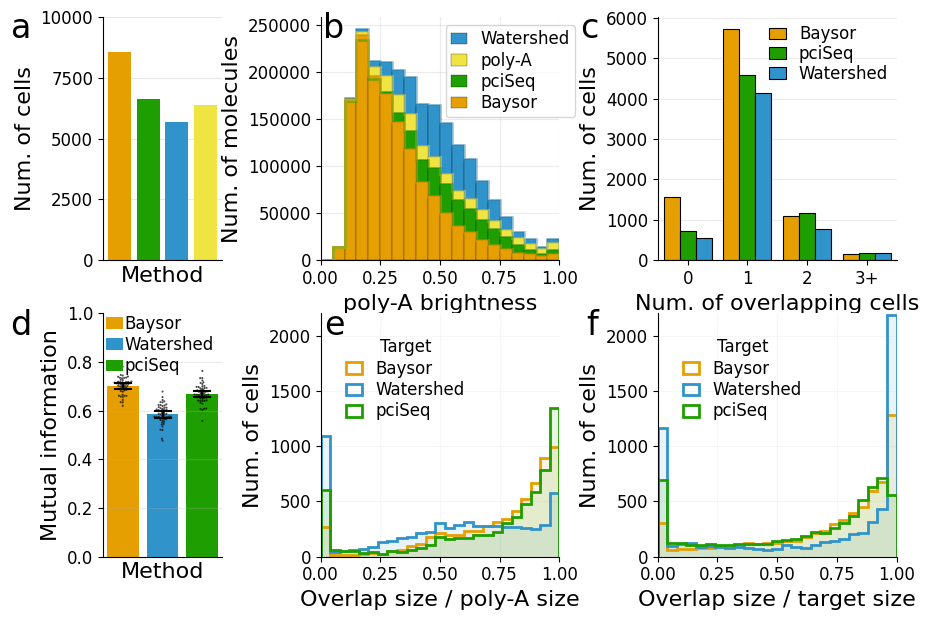

In [8]:
fig, axes = Plt.subplots(2, 3, figsize=(9, 6), gridspec_kw=Dict(:width_ratios => [1, 2, 2]));
ax_ncells, ax_mi, ax_bright, ax_recall, ax_nover, ax_precision = axes

## Precision / recall

p_keys = [:match_res_cell_polya => "Baysor", :match_res_watershed_polya => "Watershed", :match_res_pciseq_polya => "pciSeq"]
bins = 0.0:0.04:1.0
p_alpha = 0.1
lw = 2
for (k, l) in p_keys
    df = BA.precision_recall_df(data[k].contingency)
    col = color_per_label[l]
    
    ax_recall.hist(df.recall, bins=bins, alpha=p_alpha, color=col);
    ax_recall.hist(df.recall, bins=bins, label=l, histtype="step", color=col, lw=lw);
    
    ax_precision.hist(df.precision, bins=bins, alpha=p_alpha, color=col);
    ax_precision.hist(df.precision, bins=bins, label=l, histtype="step", color=col, lw=lw);
end

for ax in (ax_precision, ax_recall)
    ax.grid(true, alpha=0.1)
    ax.set_ylabel("Num. of cells");
    ax.set_ylim(0, 2200)
    ax.set_xlim(0, 1);
    ax.legend(title="Target", loc="upper left", borderpad=1, handlelength=1, labelspacing=0.2);
end

ax_recall.set_xlabel("Overlap size / poly-A size")
ax_precision.set_xlabel("Overlap size / target size")

## Mutual information

# Sns.barplot(x=mi_df.lab, y=mi_df.mi, palette=color_per_label, saturation=1, capsize=0.2, errwidth=1.5, ci=95, ax=ax_mi)

Sns.barplot(x=mi_df.lab, y=mi_df.mi, ax=ax_mi, palette=color_per_label, saturation=1, zorder=0)
Sns.swarmplot(x=mi_df.lab, y=mi_df.mi, color="black", ax=ax_mi, s=1.5, zorder=1, alpha=0.7)
Sns.pointplot(x=mi_df.lab, y=mi_df.mi, color="black", ax=ax_mi, join=false, errwidth=1.5, ci=99, scale=0, capsize=0.4, zorder=2)

ax_mi.set_ylim(0, 1)
ax_mi.legend(handles=[Plt.matplotlib.patches.Patch(facecolor=color_per_label[cell_cols_aliases[c]], label=cell_cols_aliases[c]) for c in plot_cols], 
    loc="upper right", handlelength=1, labelspacing=0.2, bbox_to_anchor=(1., 1.03), handletextpad=0.1)
ax_mi.set_xlabel("Method"); ax_mi.set_ylabel("Mutual information");
ax_mi.set_xticks([]);

## Num. overlaps

Sns.barplot(x=ovr_counts.NOverlaps, y=ovr_counts.NCells, hue=ovr_counts.Type, palette=color_per_label, edgecolor="black", 
    linewidth=0.8, saturation=1, ax=ax_nover)
ax_nover.set_ylabel("Num. of cells"); ax_nover.set_xlabel("Num. of overlapping cells");
ax_nover.legend(handlelength=1, labelspacing=0.1)

## Poly-A brightness

bins = 0.0:0.05:1.0
p_cols = [:cell_watershed, :cell_polya, :cell_pciseq, :cell]
for s in p_cols
    t = cell_cols_aliases[s]
    ax_bright.hist(df_spatial.polya_brightness[df_spatial[!, s] .== 0], bins=bins, label=t, color=color_per_label[t], alpha=1.0, edgecolor="black", lw=0.2)
end

for s in p_cols
    ax_bright.hist(df_spatial.polya_brightness[df_spatial[!, s] .== 0], bins=bins, label="", color=color_per_label[cell_cols_aliases[s]], 
        histtype="step", lw=2, alpha=0.5)
end

ax_bright.set_xlim(0, 1)
ax_bright.set_xlabel("poly-A brightness"); ax_bright.set_ylabel("Num. of molecules")
ax_bright.legend(loc="upper right", handlelength=1.0, labelspacing=0.2, frameon=true, borderpad=0.3, bbox_to_anchor=(1.1, 1.0));

## Num. cells

ax_ncells.bar(1:length(cell_cols), [size(data[:qc_per_cell_dfs][k], 1) for k in cell_cols], color=[color_per_label[cell_cols_aliases[c]] for c in cell_cols])
ax_ncells.set_xticks([]); ax_ncells.set_yticks(0:2500:10000);
ax_ncells.set_xlabel("Method"); ax_ncells.set_ylabel("Num. of cells");
ax_ncells.grid(true, axis=:y, alpha=0.3)

## Save

Plt.tight_layout(pad=0);

for (ax, lab, x) in zip(vec(permutedims(axes)), ["a", "b", "c", "d", "e", "f"], repeat([-0.6, 0.1, -0.25], outer=2))
    BA.label_axis!(ax, lab, x=x, y=1.02)
end

Plt.savefig(plotsdir("benchmarking/merfish_polya_benchmarks.pdf"), transparent=true)